In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from sklearn.metrics import r2_score
from sklearn import preprocessing
#import scipy.io as sio

from models import VAE,AEBase,Predictor
from models import DNN
import numpy as np
import pandas as pd
import models
import utils as ut
import copy

from scipy import stats


In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in M

In [2]:
from scipy.stats import pearsonr

# Parameters

In [3]:
# Define parameters
epochs = 500 #200,500,1000  
#dim_au_in = 20049
dim_au_out = 512 #8, 16, 32, 64, 128, 256,512
dim_dnn_in = dim_au_out
dim_dnn_out=1
select_drug = 'Tamoxifen'
na = -1

# Import data

In [4]:
data_r=pd.read_csv('data/GDSC2_expression.csv',index_col=0)
label_r=pd.read_csv('data/GDSC2_label_9drugs.csv',index_col=0)

In [5]:
label_r=label_r.fillna(na)

In [6]:
hvg,adata = ut.highly_variable_genes(data_r)

In [7]:
selected_idx = label_r.loc[:,select_drug]!=na

In [8]:
data_r.columns = adata.var_names

# Your is gene-cell, mine is cell-gene

In [9]:
#data = data_r.loc[selected_idx,:]
data = data_r.loc[selected_idx,hvg]

In [10]:
label = label_r.loc[selected_idx,select_drug]
#sscaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
mmscaler = preprocessing.MinMaxScaler()
lbscaler = preprocessing.MinMaxScaler()

data = mmscaler.fit_transform(data)
label = lbscaler.fit_transform(label.values.reshape(-1,1))
#label = label.values.reshape(-1,1)

In [11]:
print(np.std(data))
print(np.mean(data))

0.25175280608528416
0.24212160701395455


In [12]:
data.mean(axis=0)


array([0.47806461, 0.07789249, 0.20505775, ..., 0.12038875, 0.05430149,
       0.40485924])

In [13]:
print(data.max())
print(data.min())

1.0000000000000004
0.0


In [14]:
data.shape

(804, 5116)

In [15]:
label_r.shape

(804, 9)

# Split test train

In [16]:
from sklearn.model_selection import train_test_split
X_train_all, X_test, Y_train_all, Y_test = train_test_split(data, label, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_all, Y_train_all, test_size=0.2, random_state=42)

In [17]:
print(data.shape)
print(label.shape)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(804, 5116)
(804, 1)
(514, 5116) (514, 1)
(161, 5116) (161, 1)


In [18]:
print(X_train.max())
print(X_train.min())

1.0000000000000004
0.0


# AE MODEL

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
torch.cuda.set_device(device)

cuda:0


# Add all data to AE

In [20]:
X_trainTensor = torch.FloatTensor(X_train).to(device)
X_validTensor = torch.FloatTensor(X_valid).to(device)
X_testTensor = torch.FloatTensor(X_test).to(device)
X_allTensor = torch.FloatTensor(data).to(device)
#X_alltrainTensor = torch.FloatTensor(X_train_all).to(device)


Y_trainTensor = torch.FloatTensor(Y_train).to(device)
Y_validTensor = torch.FloatTensor(Y_valid).to(device)

# construct TensorDataset
train_dataset = TensorDataset(X_trainTensor, X_trainTensor)
valid_dataset = TensorDataset(X_validTensor, X_validTensor)
test_dataset = TensorDataset(X_testTensor, X_testTensor)
all_dataset = TensorDataset(X_allTensor, X_allTensor)

X_trainDataLoader = DataLoader(dataset=train_dataset, batch_size=200, shuffle=True)
X_validDataLoader = DataLoader(dataset=valid_dataset, batch_size=200, shuffle=True)
X_allDataLoader = DataLoader(dataset=all_dataset, batch_size=200, shuffle=True)

In [21]:
dataloader = X_trainDataLoader

In [22]:
dataloaders_train = {'train':X_trainDataLoader,'val':X_validDataLoader}

# The model

In [23]:
model = AEBase(input_dim=data.shape[1],latent_dim=256,hidden_dims=[1024,512])

In [24]:
print(model)

AEBase(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=5116, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (bottleneck): Linear(in_features=512, out_features=256, bias=True)
  (decoder_input): Linear(in_features=256, out_features=512, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (final_layer): Sequential(
    (0): Linear(in_features=1024, out_features=5116, bias=True)
    (1): Sigmoid()
  )

In [25]:
#model = VAE(dim_au_in=data_r.shape[1],dim_au_out=128)
if torch.cuda.is_available():
    model.cuda()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_function = nn.MSELoss()

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)

In [26]:
def train_ae_model(net,data_loaders={},optimizer=None,loss_function=None,n_epochs=100,scheduler=None,load=None):
    
    if(load!=None):
        net.load_state_dict(torch.load(load))           
    
        return net, 0
    
    dataset_sizes = {x: data_loaders[x].dataset.tensors[0].shape[0] for x in ['train', 'val']}
    loss_train = {}
    
    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = np.inf

    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #optimizer = scheduler(optimizer, epoch)
                net.train()  # Set model to training mode
            else:
                net.eval()  # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            # for data in data_loaders[phase]:
            for batchidx, (x, _) in enumerate(data_loaders[phase]):

                x.requires_grad_(True)
                # encode and decode 
                output = net(x)
                # compute loss
                loss = loss_function(output, x)      

                # zero the parameter (weight) gradients
                optimizer.zero_grad()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    # update the weights
                    optimizer.step()

                # print loss statistics
                running_loss += loss.item()
            
            # Schedular
#             if phase == 'train':
#                 scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step(epoch_loss)
                
            last_lr = scheduler.optimizer.param_groups[0]['lr']
            loss_train[epoch,phase] = epoch_loss
            print('{} Loss: {:.8f}. Learning rate = {}'.format(phase, epoch_loss,last_lr))
            
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(net.state_dict())
    
    # Select best model wts
    torch.save(best_model_wts, 'saved/models/GDSC_512_256_128.pkl')
    net.load_state_dict(best_model_wts)           
    
    return net, loss_train

In [27]:
model,loss_report = train_ae_model(net=model,data_loaders=dataloaders_train,
                             optimizer=optimizer,loss_function=loss_function,
                            n_epochs=epochs,scheduler=exp_lr_scheduler)

# If not trained use above
#model,loss_report = train_ae_model(net=model,load='saved/models/ae.pkl')

Epoch 0/499
----------
train Loss: 0.00100130. Learning rate = 0.01
val Loss: 0.00314581. Learning rate = 0.01
Epoch 1/499
----------
train Loss: 0.00149215. Learning rate = 0.01
val Loss: 0.00263956. Learning rate = 0.01
Epoch 2/499
----------
train Loss: 0.00114590. Learning rate = 0.01
val Loss: 0.00255746. Learning rate = 0.01
Epoch 3/499
----------
train Loss: 0.00089322. Learning rate = 0.01
val Loss: 0.00200176. Learning rate = 0.01
Epoch 4/499
----------
train Loss: 0.00068268. Learning rate = 0.01
val Loss: 0.00172736. Learning rate = 0.01
Epoch 5/499
----------
train Loss: 0.00053478. Learning rate = 0.01
val Loss: 0.00151194. Learning rate = 0.01
Epoch 6/499
----------
train Loss: 0.00044755. Learning rate = 0.01
val Loss: 0.00127555. Learning rate = 0.01
Epoch 7/499
----------
train Loss: 0.00040424. Learning rate = 0.01
val Loss: 0.00097171. Learning rate = 0.01
Epoch 8/499
----------
train Loss: 0.00038746. Learning rate = 0.01
val Loss: 0.00083812. Learning rate = 0.01
E

val Loss: 0.00018869. Learning rate = 0.01
Epoch 77/499
----------
train Loss: 0.00013788. Learning rate = 0.01
val Loss: 0.00018772. Learning rate = 0.01
Epoch 78/499
----------
train Loss: 0.00013595. Learning rate = 0.01
val Loss: 0.00018891. Learning rate = 0.01
Epoch 79/499
----------
train Loss: 0.00013640. Learning rate = 0.01
val Loss: 0.00018809. Learning rate = 0.01
Epoch 80/499
----------
train Loss: 0.00013660. Learning rate = 0.01
val Loss: 0.00018771. Learning rate = 0.01
Epoch 81/499
----------
train Loss: 0.00013722. Learning rate = 0.01
val Loss: 0.00018704. Learning rate = 0.01
Epoch 82/499
----------
train Loss: 0.00013570. Learning rate = 0.01
val Loss: 0.00018623. Learning rate = 0.01
Epoch 83/499
----------
train Loss: 0.00013610. Learning rate = 0.01
val Loss: 0.00018542. Learning rate = 0.01
Epoch 84/499
----------
train Loss: 0.00013473. Learning rate = 0.01
val Loss: 0.00018550. Learning rate = 0.01
Epoch 85/499
----------
train Loss: 0.00013538. Learning rate

val Loss: 0.00016479. Learning rate = 0.01
Epoch 152/499
----------
train Loss: 0.00012005. Learning rate = 0.01
val Loss: 0.00016427. Learning rate = 0.01
Epoch 153/499
----------
train Loss: 0.00012033. Learning rate = 0.01
val Loss: 0.00016407. Learning rate = 0.01
Epoch 154/499
----------
train Loss: 0.00011942. Learning rate = 0.01
val Loss: 0.00016391. Learning rate = 0.01
Epoch 155/499
----------
train Loss: 0.00011949. Learning rate = 0.01
val Loss: 0.00016460. Learning rate = 0.01
Epoch 156/499
----------
train Loss: 0.00011878. Learning rate = 0.01
val Loss: 0.00016426. Learning rate = 0.01
Epoch 157/499
----------
train Loss: 0.00011907. Learning rate = 0.01
val Loss: 0.00016374. Learning rate = 0.01
Epoch 158/499
----------
train Loss: 0.00011994. Learning rate = 0.01
val Loss: 0.00016408. Learning rate = 0.01
Epoch 159/499
----------
train Loss: 0.00011893. Learning rate = 0.01
val Loss: 0.00016365. Learning rate = 0.01
Epoch 160/499
----------
train Loss: 0.00011819. Lear

val Loss: 0.00016076. Learning rate = 0.0001
Epoch 226/499
----------
train Loss: 0.00011593. Learning rate = 0.0001
val Loss: 0.00016076. Learning rate = 0.0001
Epoch 227/499
----------
train Loss: 0.00011583. Learning rate = 0.0001
val Loss: 0.00016077. Learning rate = 0.0001
Epoch 228/499
----------
train Loss: 0.00011590. Learning rate = 0.0001
val Loss: 0.00016077. Learning rate = 0.0001
Epoch 229/499
----------
train Loss: 0.00011595. Learning rate = 0.0001
val Loss: 0.00016076. Learning rate = 0.0001
Epoch 230/499
----------
train Loss: 0.00011550. Learning rate = 0.0001
val Loss: 0.00016077. Learning rate = 0.0001
Epoch 231/499
----------
train Loss: 0.00011569. Learning rate = 0.0001
val Loss: 0.00016079. Learning rate = 0.0001
Epoch 232/499
----------
train Loss: 0.00011557. Learning rate = 1e-05
val Loss: 0.00016079. Learning rate = 1e-05
Epoch 233/499
----------
train Loss: 0.00011631. Learning rate = 1e-05
val Loss: 0.00016080. Learning rate = 1e-05
Epoch 234/499
---------

val Loss: 0.00016079. Learning rate = 1.0000000000000004e-08
Epoch 286/499
----------
train Loss: 0.00011640. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016080. Learning rate = 1.0000000000000004e-08
Epoch 287/499
----------
train Loss: 0.00011638. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016080. Learning rate = 1.0000000000000004e-08
Epoch 288/499
----------
train Loss: 0.00011563. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016081. Learning rate = 1.0000000000000004e-08
Epoch 289/499
----------
train Loss: 0.00011525. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016080. Learning rate = 1.0000000000000004e-08
Epoch 290/499
----------
train Loss: 0.00011590. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016080. Learning rate = 1.0000000000000004e-08
Epoch 291/499
----------
train Loss: 0.00011573. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016080. Learning rate = 1.0000000000000004e-08
Epoch 292/499
----------
train Loss: 0.000115

train Loss: 0.00011551. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016077. Learning rate = 1.0000000000000004e-08
Epoch 342/499
----------
train Loss: 0.00011563. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016079. Learning rate = 1.0000000000000004e-08
Epoch 343/499
----------
train Loss: 0.00011589. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016077. Learning rate = 1.0000000000000004e-08
Epoch 344/499
----------
train Loss: 0.00011535. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016077. Learning rate = 1.0000000000000004e-08
Epoch 345/499
----------
train Loss: 0.00011598. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016076. Learning rate = 1.0000000000000004e-08
Epoch 346/499
----------
train Loss: 0.00011609. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016076. Learning rate = 1.0000000000000004e-08
Epoch 347/499
----------
train Loss: 0.00011502. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016077. Learning rate = 1.000

val Loss: 0.00016079. Learning rate = 1.0000000000000004e-08
Epoch 398/499
----------
train Loss: 0.00011524. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016080. Learning rate = 1.0000000000000004e-08
Epoch 399/499
----------
train Loss: 0.00011524. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016079. Learning rate = 1.0000000000000004e-08
Epoch 400/499
----------
train Loss: 0.00011509. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016079. Learning rate = 1.0000000000000004e-08
Epoch 401/499
----------
train Loss: 0.00011570. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016078. Learning rate = 1.0000000000000004e-08
Epoch 402/499
----------
train Loss: 0.00011578. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016080. Learning rate = 1.0000000000000004e-08
Epoch 403/499
----------
train Loss: 0.00011539. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016079. Learning rate = 1.0000000000000004e-08
Epoch 404/499
----------
train Loss: 0.000115

val Loss: 0.00016078. Learning rate = 1.0000000000000004e-08
Epoch 453/499
----------
train Loss: 0.00011602. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016076. Learning rate = 1.0000000000000004e-08
Epoch 454/499
----------
train Loss: 0.00011556. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016077. Learning rate = 1.0000000000000004e-08
Epoch 455/499
----------
train Loss: 0.00011661. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016077. Learning rate = 1.0000000000000004e-08
Epoch 456/499
----------
train Loss: 0.00011612. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016077. Learning rate = 1.0000000000000004e-08
Epoch 457/499
----------
train Loss: 0.00011563. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016076. Learning rate = 1.0000000000000004e-08
Epoch 458/499
----------
train Loss: 0.00011562. Learning rate = 1.0000000000000004e-08
val Loss: 0.00016077. Learning rate = 1.0000000000000004e-08
Epoch 459/499
----------
train Loss: 0.000115

In [28]:
loss_report

{(0, 'train'): 0.0010012959633819787,
 (0, 'val'): 0.003145810476569242,
 (1, 'train'): 0.00149215276603105,
 (1, 'val'): 0.0026395646638648455,
 (2, 'train'): 0.0011459030066018902,
 (2, 'val'): 0.0025574571864549504,
 (3, 'train'): 0.0008932227406520324,
 (3, 'val'): 0.0020017598488534143,
 (4, 'train'): 0.0006826782910740329,
 (4, 'val'): 0.0017273554275202196,
 (5, 'train'): 0.0005347837733851332,
 (5, 'val'): 0.00151193546232327,
 (6, 'train'): 0.0004475535208844953,
 (6, 'val'): 0.0012755522201227587,
 (7, 'train'): 0.0004042401503959982,
 (7, 'val'): 0.0009717086488886397,
 (8, 'train'): 0.0003874608050988342,
 (8, 'val'): 0.0008381158691044002,
 (9, 'train'): 0.0003729064147991893,
 (9, 'val'): 0.0007696132673773655,
 (10, 'train'): 0.000356070950975214,
 (10, 'val'): 0.0006486003597577413,
 (11, 'train'): 0.00034695185344042946,
 (11, 'val'): 0.0005739365899285605,
 (12, 'train'): 0.0003362530371326417,
 (12, 'val'): 0.0005332943658496058,
 (13, 'train'): 0.0003231870380125157

In [29]:
# # Old code for autoencoders
# for epoch in range(epochs):
#     # 不需要label，所以用一个占位符"_"代替
#     for batchidx, (x, _) in enumerate(X_allDataLoader):
#         x.requires_grad_(True)
#         # encode and decode 
#         output = model(x)
#         # compute loss
#         print(output.shape)
#         loss = loss_function(output, x)      
#         # update
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
           
#     loss_train[epoch,0] = loss.item()  
#     print('Epoch: %04d, Training loss=%.8f' %
#           (epoch+1, loss.item()))

In [30]:
# torch.save(model.state_dict(), 'saved/models/ae.pkl')

In [31]:
recon_batch = model(X_trainTensor)

In [32]:
loss_function(recon_batch,X_trainTensor)

tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward>)

In [33]:
recon_batch

tensor([[0.0179, 0.2203, 0.0598,  ..., 0.0744, 0.0359, 0.4625],
        [0.4982, 0.0103, 0.0481,  ..., 0.1477, 0.0783, 0.5817],
        [0.4635, 0.0266, 0.0524,  ..., 0.1124, 0.1585, 0.5717],
        ...,
        [0.4610, 0.0327, 0.1604,  ..., 0.0703, 0.0289, 0.4357],
        [0.5004, 0.0081, 0.0499,  ..., 0.0880, 0.0459, 0.5970],
        [0.5049, 0.0603, 0.3683,  ..., 0.0408, 0.0119, 0.3265]],
       device='cuda:0', grad_fn=<SigmoidBackward>)

In [34]:
X_trainTensor

tensor([[0.0355, 0.0408, 0.0855,  ..., 0.1037, 0.0339, 0.2028],
        [0.3025, 0.0043, 0.0373,  ..., 0.0246, 0.0239, 0.4718],
        [0.0812, 0.0273, 0.0615,  ..., 0.0671, 0.0704, 0.8705],
        ...,
        [0.7647, 0.0856, 0.0655,  ..., 0.0515, 0.0366, 0.0566],
        [0.3283, 0.0236, 0.0613,  ..., 0.0621, 0.0321, 0.9801],
        [0.5512, 0.0427, 0.7913,  ..., 0.0581, 0.0139, 0.2744]],
       device='cuda:0')

In [35]:
recon_batch.cpu().detach().numpy().min()

1.180778e-12

In [36]:
train_embeddings = model.encode(X_trainTensor)

In [37]:
feature = train_embeddings.cpu().detach().numpy()

In [38]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.001)
clf.fit(feature, Y_train)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4582099914550781, tolerance: 0.0016416084254160523
  positive)


Lasso(alpha=0.001)

In [39]:
from sklearn.ensemble import RandomForestRegressor
RFrg = RandomForestRegressor(random_state=0, n_estimators=100)
RFrg.fit(feature, Y_train)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(random_state=0)

In [40]:
testFeature = model.encode(X_testTensor)
lasso = clf.predict(testFeature.detach().cpu().numpy())

In [41]:
rfresult = RFrg.predict(testFeature.detach().cpu().numpy())

In [42]:
from scipy import stats


In [43]:
r2_score(lasso,Y_test)

-36.72582547536633

In [44]:
stats.pearsonr(lasso,Y_test.flatten())

(0.09505035059431877, 0.23038260264480376)

In [45]:
r2_score(rfresult,Y_test)

-8.588769110731901

In [46]:
stats.pearsonr(rfresult,Y_test.flatten())

(-0.0001288515308037982, 0.9987056695480759)

In [47]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feature)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 514 samples in 0.015s...
[t-SNE] Computed neighbors for 514 samples in 0.141s...
[t-SNE] Computed conditional probabilities for sample 514 / 514
[t-SNE] Mean sigma: 17.750224
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.959129
[t-SNE] KL divergence after 300 iterations: 0.406760


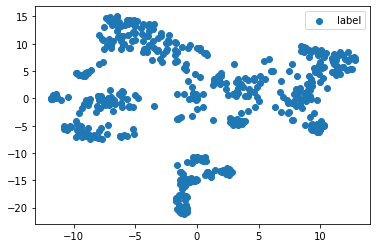

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], label="label")
plt.legend()
plt.savefig("saved/figures/tsne_ae_gdsc.png")

In [49]:
EPOCH = 500

In [50]:
X_trainfeatureTensor = model.encode(X_trainTensor).detach()
#y_trainfeatureTensor = model.encode(X_trainTensor).detach()
X_validfeatureTensor = model.encode(X_validTensor).detach()
#y_validfeatureTensor = model.encode(X_trainTensor).detach()
X_testfeatureTensor = model.encode(X_testTensor).detach()
#y_testfeatureTensor = model.encode(X_trainTensor).detach()

In [51]:
# Load data
# data type conversion

# y_trainTensor = torch.FloatTensor(Y_train).to(device)
# y_validTensor = torch.FloatTensor(Y_valid).to(device)

# construct TensorDataset
trainreducedDataset = TensorDataset(X_trainfeatureTensor, Y_trainTensor)
validreducedDataset = TensorDataset(X_validfeatureTensor, Y_validTensor)

trainDataLoader_p = DataLoader(dataset=trainreducedDataset, batch_size=200, shuffle=True)
validDataLoader_p = DataLoader(dataset=trainreducedDataset, batch_size=200, shuffle=True)

In [52]:
dataloaders_train_p = {'train':trainDataLoader_p,'val':validDataLoader_p}

In [53]:
predictor = Predictor(input_dim=256, output_dim=1,hidden_dims=[128,64],drop_out=0.3)

In [54]:
print(predictor)

Predictor(
  (predictor): Sequential(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (output): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [55]:
predictor.to(device)
optimizer_p = optim.Adam(predictor.parameters(), lr=1e-2)
loss_function_p = nn.MSELoss()

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
lr_scheduler_p = lr_scheduler.ReduceLROnPlateau(optimizer_p)

In [56]:
def train_predictor_model(net,data_loaders,optimizer,loss_function,n_epochs,scheduler,drugName=None):
    
    dataset_sizes = {x: data_loaders[x].dataset.tensors[0].shape[0] for x in ['train', 'val']}
    loss_train = {}
    
    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = np.inf

    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #optimizer = scheduler(optimizer, epoch)
                net.train()  # Set model to training mode
            else:
                net.eval()  # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            # for data in data_loaders[phase]:
            for batchidx, (x, y) in enumerate(data_loaders[phase]):

                x.requires_grad_(True)
                # encode and decode 
                output = net(x)
                # compute loss
                loss = loss_function(output, y)      

                # zero the parameter (weight) gradients
                optimizer.zero_grad()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    # update the weights
                    optimizer.step()

                # print loss statistics
                running_loss += loss.item()
            
            # Schedular
#             if phase == 'train':
#                 scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            
            if phase == 'train':
                scheduler.step(epoch_loss)
                
            last_lr = scheduler.optimizer.param_groups[0]['lr']
            loss_train[epoch,phase] = epoch_loss
            print('{} Loss: {:.8f}. Learning rate = {}'.format(phase, epoch_loss,last_lr))
            
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(net.state_dict())
    
    # Select best model wts
    if drugName == None:
        torch.save(best_model_wts, 'saved/models/predictor.pkl')
    else:
        torch.save(best_model_wts, 'saved/models/predictor_'+drugName+'.pkl')
        
    net.load_state_dict(best_model_wts)           
    
    return net, loss_train

In [57]:
predictor,p_loss_report = train_predictor_model(predictor,dataloaders_train_p,optimizer_p,loss_function_p,500,lr_scheduler_p)

Epoch 0/499
----------
train Loss: 0.00063426. Learning rate = 0.01
val Loss: 0.00088087. Learning rate = 0.01
Epoch 1/499
----------
train Loss: 0.00040031. Learning rate = 0.01
val Loss: 0.00044595. Learning rate = 0.01
Epoch 2/499
----------
train Loss: 0.00034874. Learning rate = 0.01
val Loss: 0.00039118. Learning rate = 0.01
Epoch 3/499
----------
train Loss: 0.00030272. Learning rate = 0.01
val Loss: 0.00028799. Learning rate = 0.01
Epoch 4/499
----------
train Loss: 0.00027244. Learning rate = 0.01
val Loss: 0.00025202. Learning rate = 0.01
Epoch 5/499
----------
train Loss: 0.00024677. Learning rate = 0.01
val Loss: 0.00023790. Learning rate = 0.01
Epoch 6/499
----------
train Loss: 0.00023352. Learning rate = 0.01
val Loss: 0.00019294. Learning rate = 0.01
Epoch 7/499
----------
train Loss: 0.00021041. Learning rate = 0.01
val Loss: 0.00017964. Learning rate = 0.01
Epoch 8/499
----------
train Loss: 0.00021298. Learning rate = 0.01
val Loss: 0.00019064. Learning rate = 0.01
E

val Loss: 0.00017868. Learning rate = 1.0000000000000002e-06
Epoch 74/499
----------
train Loss: 0.00018865. Learning rate = 1.0000000000000002e-06
val Loss: 0.00018621. Learning rate = 1.0000000000000002e-06
Epoch 75/499
----------
train Loss: 0.00018547. Learning rate = 1.0000000000000002e-06
val Loss: 0.00018506. Learning rate = 1.0000000000000002e-06
Epoch 76/499
----------
train Loss: 0.00018792. Learning rate = 1.0000000000000002e-06
val Loss: 0.00018415. Learning rate = 1.0000000000000002e-06
Epoch 77/499
----------
train Loss: 0.00018042. Learning rate = 1.0000000000000002e-07
val Loss: 0.00018227. Learning rate = 1.0000000000000002e-07
Epoch 78/499
----------
train Loss: 0.00018310. Learning rate = 1.0000000000000002e-07
val Loss: 0.00018360. Learning rate = 1.0000000000000002e-07
Epoch 79/499
----------
train Loss: 0.00017944. Learning rate = 1.0000000000000002e-07
val Loss: 0.00018608. Learning rate = 1.0000000000000002e-07
Epoch 80/499
----------
train Loss: 0.00018942. Lea

train Loss: 0.00018592. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018032. Learning rate = 1.0000000000000004e-08
Epoch 132/499
----------
train Loss: 0.00018365. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018360. Learning rate = 1.0000000000000004e-08
Epoch 133/499
----------
train Loss: 0.00018413. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017853. Learning rate = 1.0000000000000004e-08
Epoch 134/499
----------
train Loss: 0.00018965. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017616. Learning rate = 1.0000000000000004e-08
Epoch 135/499
----------
train Loss: 0.00018910. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018275. Learning rate = 1.0000000000000004e-08
Epoch 136/499
----------
train Loss: 0.00018496. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017999. Learning rate = 1.0000000000000004e-08
Epoch 137/499
----------
train Loss: 0.00019083. Learning rate = 1.0000000000000004e-08
val Loss: 0.00019265. Learning rate = 1.000

train Loss: 0.00018749. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018691. Learning rate = 1.0000000000000004e-08
Epoch 189/499
----------
train Loss: 0.00018712. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018240. Learning rate = 1.0000000000000004e-08
Epoch 190/499
----------
train Loss: 0.00018858. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018171. Learning rate = 1.0000000000000004e-08
Epoch 191/499
----------
train Loss: 0.00018690. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018215. Learning rate = 1.0000000000000004e-08
Epoch 192/499
----------
train Loss: 0.00018430. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018617. Learning rate = 1.0000000000000004e-08
Epoch 193/499
----------
train Loss: 0.00018647. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018353. Learning rate = 1.0000000000000004e-08
Epoch 194/499
----------
train Loss: 0.00019235. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018141. Learning rate = 1.000

train Loss: 0.00018315. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017683. Learning rate = 1.0000000000000004e-08
Epoch 245/499
----------
train Loss: 0.00019197. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018383. Learning rate = 1.0000000000000004e-08
Epoch 246/499
----------
train Loss: 0.00017744. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018176. Learning rate = 1.0000000000000004e-08
Epoch 247/499
----------
train Loss: 0.00018170. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018202. Learning rate = 1.0000000000000004e-08
Epoch 248/499
----------
train Loss: 0.00018766. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018733. Learning rate = 1.0000000000000004e-08
Epoch 249/499
----------
train Loss: 0.00018853. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018279. Learning rate = 1.0000000000000004e-08
Epoch 250/499
----------
train Loss: 0.00019597. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018766. Learning rate = 1.000

val Loss: 0.00018246. Learning rate = 1.0000000000000004e-08
Epoch 301/499
----------
train Loss: 0.00019514. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018282. Learning rate = 1.0000000000000004e-08
Epoch 302/499
----------
train Loss: 0.00018680. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018110. Learning rate = 1.0000000000000004e-08
Epoch 303/499
----------
train Loss: 0.00019128. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017942. Learning rate = 1.0000000000000004e-08
Epoch 304/499
----------
train Loss: 0.00018528. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017703. Learning rate = 1.0000000000000004e-08
Epoch 305/499
----------
train Loss: 0.00018626. Learning rate = 1.0000000000000004e-08
val Loss: 0.00019184. Learning rate = 1.0000000000000004e-08
Epoch 306/499
----------
train Loss: 0.00018983. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017848. Learning rate = 1.0000000000000004e-08
Epoch 307/499
----------
train Loss: 0.000191

val Loss: 0.00017975. Learning rate = 1.0000000000000004e-08
Epoch 360/499
----------
train Loss: 0.00018647. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018521. Learning rate = 1.0000000000000004e-08
Epoch 361/499
----------
train Loss: 0.00019029. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018146. Learning rate = 1.0000000000000004e-08
Epoch 362/499
----------
train Loss: 0.00018901. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018465. Learning rate = 1.0000000000000004e-08
Epoch 363/499
----------
train Loss: 0.00018301. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018341. Learning rate = 1.0000000000000004e-08
Epoch 364/499
----------
train Loss: 0.00019007. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018004. Learning rate = 1.0000000000000004e-08
Epoch 365/499
----------
train Loss: 0.00018143. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018068. Learning rate = 1.0000000000000004e-08
Epoch 366/499
----------
train Loss: 0.000181

val Loss: 0.00018159. Learning rate = 1.0000000000000004e-08
Epoch 419/499
----------
train Loss: 0.00018166. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017986. Learning rate = 1.0000000000000004e-08
Epoch 420/499
----------
train Loss: 0.00019187. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017676. Learning rate = 1.0000000000000004e-08
Epoch 421/499
----------
train Loss: 0.00018145. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018217. Learning rate = 1.0000000000000004e-08
Epoch 422/499
----------
train Loss: 0.00018931. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017743. Learning rate = 1.0000000000000004e-08
Epoch 423/499
----------
train Loss: 0.00018996. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018135. Learning rate = 1.0000000000000004e-08
Epoch 424/499
----------
train Loss: 0.00018674. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018066. Learning rate = 1.0000000000000004e-08
Epoch 425/499
----------
train Loss: 0.000192

val Loss: 0.00018878. Learning rate = 1.0000000000000004e-08
Epoch 477/499
----------
train Loss: 0.00018023. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018059. Learning rate = 1.0000000000000004e-08
Epoch 478/499
----------
train Loss: 0.00018280. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018260. Learning rate = 1.0000000000000004e-08
Epoch 479/499
----------
train Loss: 0.00018807. Learning rate = 1.0000000000000004e-08
val Loss: 0.00017807. Learning rate = 1.0000000000000004e-08
Epoch 480/499
----------
train Loss: 0.00018817. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018679. Learning rate = 1.0000000000000004e-08
Epoch 481/499
----------
train Loss: 0.00019585. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018017. Learning rate = 1.0000000000000004e-08
Epoch 482/499
----------
train Loss: 0.00019620. Learning rate = 1.0000000000000004e-08
val Loss: 0.00018117. Learning rate = 1.0000000000000004e-08
Epoch 483/499
----------
train Loss: 0.000182

In [58]:
testpredict = predictor(X_testfeatureTensor)

In [59]:
testpredict

tensor([[0.6791],
        [0.6642],
        [0.6999],
        [0.6507],
        [0.6978],
        [0.6718],
        [0.6846],
        [0.6931],
        [0.7203],
        [0.6954],
        [0.7009],
        [0.6878],
        [0.6408],
        [0.6705],
        [0.6672],
        [0.7168],
        [0.7160],
        [0.6525],
        [0.7324],
        [0.7199],
        [0.7027],
        [0.6608],
        [0.7121],
        [0.7203],
        [0.7051],
        [0.6984],
        [0.6915],
        [0.6901],
        [0.6995],
        [0.6776],
        [0.6931],
        [0.7378],
        [0.7130],
        [0.6992],
        [0.6727],
        [0.6910],
        [0.6578],
        [0.6666],
        [0.7037],
        [0.7260],
        [0.6850],
        [0.7235],
        [0.6982],
        [0.6777],
        [0.6603],
        [0.6979],
        [0.6919],
        [0.6421],
        [0.7178],
        [0.7419],
        [0.6961],
        [0.7250],
        [0.7057],
        [0.7206],
        [0.6669],
        [0

In [60]:
Y_test

array([[0.6980736 ],
       [0.82154031],
       [0.43235471],
       [0.84672755],
       [0.72588386],
       [0.82337326],
       [0.45583541],
       [0.62487303],
       [0.90884466],
       [0.69459732],
       [0.87752651],
       [0.19711423],
       [0.54147385],
       [0.6482815 ],
       [0.49858466],
       [0.57551885],
       [0.74282283],
       [0.72248884],
       [0.82483601],
       [0.56042185],
       [0.84714742],
       [0.75740064],
       [0.91861436],
       [1.        ],
       [0.68433551],
       [0.86617216],
       [0.76853829],
       [0.62056153],
       [0.92195972],
       [0.74184767],
       [0.54849414],
       [0.86381551],
       [0.40319908],
       [0.80149074],
       [1.        ],
       [0.103065  ],
       [0.59818692],
       [0.58947815],
       [0.83125133],
       [0.73096284],
       [0.72789288],
       [0.66550941],
       [0.40841802],
       [0.65252076],
       [0.57731116],
       [0.54421876],
       [0.61246225],
       [0.558

In [61]:
from sklearn.metrics import mean_squared_error

In [62]:
dl_result = testpredict.detach().cpu().numpy()

In [63]:
r2_score(dl_result,Y_test)

-51.347617099477866

In [64]:
pearsonr(dl_result.flatten(),Y_test.flatten())

(0.0761900634764041, 0.3367493338209533)

In [65]:
mean_squared_error(testpredict.detach().cpu().numpy(),Y_test)

0.02668293515432703